In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [41]:
#Open data
data_file = open('Test.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer(char_level = False)

data = data_file.lower().splitlines()

data = list(filter(lambda x: x != '##', data))

new_data = data

for paragraph in range(len(data)):
    sentences = data[paragraph].split('.')
    new_data[paragraph] = sentences
    
    
data = new_data
data

[['the important thing is not to stop questioning',
  ' curiosity has its own reason for existence',
  ' one cannot help but be in awe when he contemplates the mysteries of eternity, of life, of the marvelous structure of reality',
  ' it is enough if one tries merely to comprehend a little of this mystery each day',
  ''],
 ['your letter made me very happy',
  ' i would like to come back to the matter of the skimpy birdfeed when i return to zurich',
  ' at the moment i have to leave on a business trip',
  ' if i can arrange it, i’ll go to arosa for a couple of days to see tete',
  ' when adn arrived yesterday with the letter, i was here, but they didn’t look for me properly',
  ' my train leaves in 2 hours',
  ' as regards health, incidentally, i am feeling infinitely better than last '],
 ['with brilliant sunshine and sweet chocolate, it’s grand to read about the goings on in berlin from up here',
  ' monday the schoolmastering begins',
  ' this nest zuoz is unbelievably attractive a

In [42]:
###Add start stop tokens###
start_token = '<start>'
end_token = ' <end>'
new_data = data

for paragraph in range(len(data)):
        para = data[paragraph]
        for sentence in range(len(para)):
            para[sentence] = start_token + para[sentence]
            para[sentence] = para[sentence] + end_token
        new_data[paragraph] = para

data = new_data

In [43]:
def Encode_Inputs(data, max_sentence_length):
    input_sequences = list()
    output_sequences = list()
    
    for paragraph in range(len(data)):
        para = data[paragraph]

        tokenized_sentence = para
        tokenizer.fit_on_texts(tokenized_sentence)

        #Transforms sentences into set of integers from the dictionary
        tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)

        #Pad sequences to length of max_length
        tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = 20, padding ='post', value = 0)
        total_words = len(tokenizer.word_index) + 1    

        roll_amount = tokenized_sentence.shape[1] * (tokenized_sentence.shape[0]-1)
        output_tokens = np.array(np.roll(tokenized_sentence, roll_amount))
        output_tokens[-1] = 0

        input_sequences.append(tokenized_sentence)
        output_sequences.append(output_tokens)

    input_sequences = np.vstack(input_sequences)
    output_sequences = np.vstack(output_sequences)
    
    return input_sequences, output_sequences, total_words

In [44]:
def Decode_Inputs(input_sequences):
    data = tokenizer.sequences_to_texts(input_sequences)
    return data

In [45]:
max_sentence_length = 20

input_sequences, output_sequences, total_words = Encode_Inputs(data, max_sentence_length)
print(total_words)
decoded = Decode_Inputs(output_sequences)
print(input_sequences.shape)
print(output_sequences.shape)
input_sequences

170
(23, 20)
(23, 20)


array([[  1,   4,   8,   9,   5,  10,   6,  11,  12,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  1,  13,  14,  15,  16,  17,  18,  19,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 22,  23,  24,  25,  26,  27,  28,   4,  29,   3,  30,   3,  31,
          3,   4,  32,  33,   3,  34,   2],
       [  1,  35,   5,  36,  37,   7,  38,  39,   6,  40,  41,  42,   3,
         43,  44,  45,  46,   2,   0,   0],
       [  1,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  1,  50,  16,  51,  17,  52,  53,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  1,   6,  54,  55,   3,  56,  57,   3,   4,  58,   5,   4,  59,
         60,   8,   6,  61,   3,  62,   2],
       [  1,  63,   4,  64,   6,  65,   3,  66,  67,   9,  68,  69,   2,
          0,   0,   0,   0,   0,   0,   0],
       [  1,  15,   6,  70,  71,  14,  72,  73,   3,  74,   7,  

In [ ]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, dropout):
        super(Transformer_Block, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.feed_forward = keras.Sequential([keras.layers.Dense(ff_dim, activation = "gelu"), keras.layers.Dense(embed_dim)])
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout)
        self.dropout2 = keras.layers.Dropout(dropout)
        
    def call(self, embedded_words, training):
        attention_output = self.attention(embedded_words, embedded_words)
        attention_output = self.dropout1(attention_output, training=training)
        #Residual connections from input to add/norm
        res1 = self.layer_norm1(embedded_words + attention_output)
        ffn_output = self.feed_forward(res1)
        ffn_output = self.dropout2(ffn_output, training=training)
        #Residual connections from add/norm to add/norm
        final_output = self.layer_norm2(ffn_output + res1)
        return final_output

In [11]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [12]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [13]:
#Pool encoder output with existing context matrix
class Multi_Head_Attention_Pooling(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dropout):
        super(Multi_Head_Attention_Pooling, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        
    #Pass in encoder as input[0], context matrix as input[1]
    def call(self, input_data):
        attention_output = self.attention(input_data[0], input_data[1])
        self_attention_output = self.attention(attention_output, attention_output)
        pooled_context = self_attention_output
        return pooled_context

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)

In [15]:
9#Variables
embed_dim = 128
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 8 
ff_dim = 16
dropout = 0.15
num_seeds = 9

encoder_stack = 1
decoder_stack = 1

In [16]:
#Initialize context matrix
context_encoder = tf.random.uniform(shape=(1, num_seeds, embed_dim))
context_decoder = tf.random.uniform(shape=(1, num_seeds, embed_dim))

2022-04-27 14:02:58.518752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 14:02:58.518805: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 14:02:58.518846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-klg6z): /proc/driver/nvidia/version does not exist
2022-04-27 14:02:58.519267: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


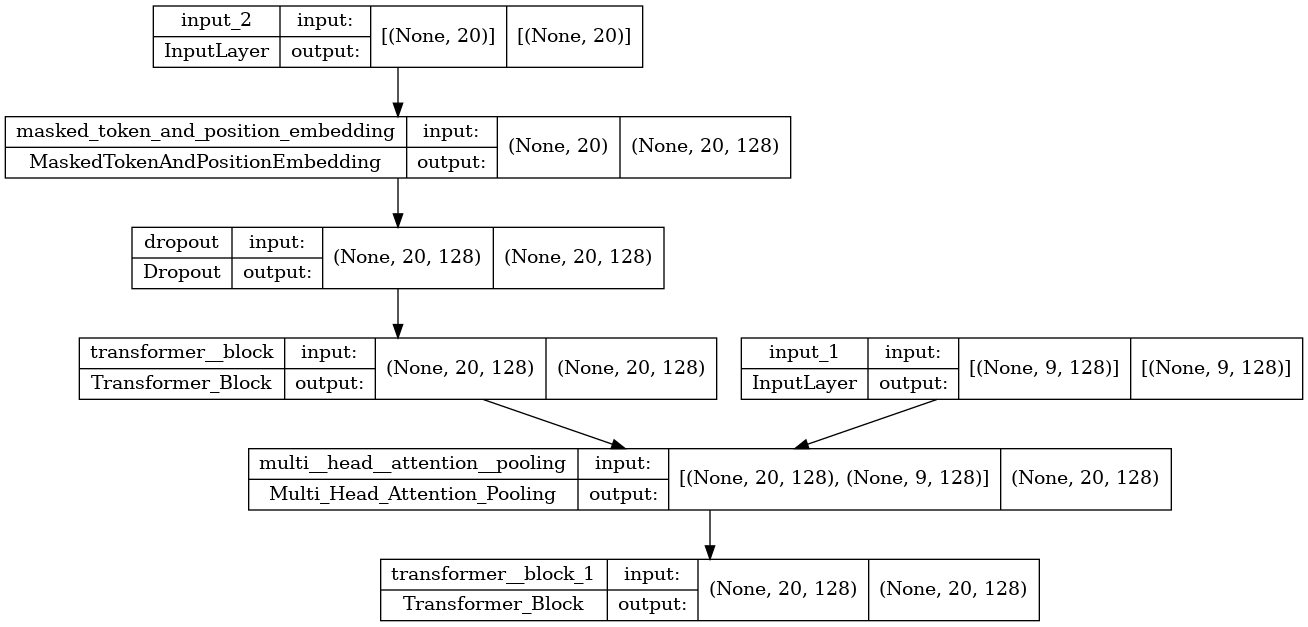

In [17]:
#Encoder

#Create layer for context
context_encoder_layer = keras.layers.Input(shape=context_encoder.shape[1:])

#Sequence input
input_layer = keras.layers.Input(shape=input_sequences.shape[1])
position_embedding_layer =  MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout
dropout = keras.layers.Dropout(dropout,noise_shape=position_embedding_layer.shape[:-1]+(1,))(position_embedding_layer)
encoder = dropout

for i in range(encoder_stack):
    encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(encoder)

context_encoder = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([encoder, context_encoder_layer])
                                                                                                  
encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(context_encoder)

encoder_model = keras.Model([input_layer, context_encoder_layer], encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

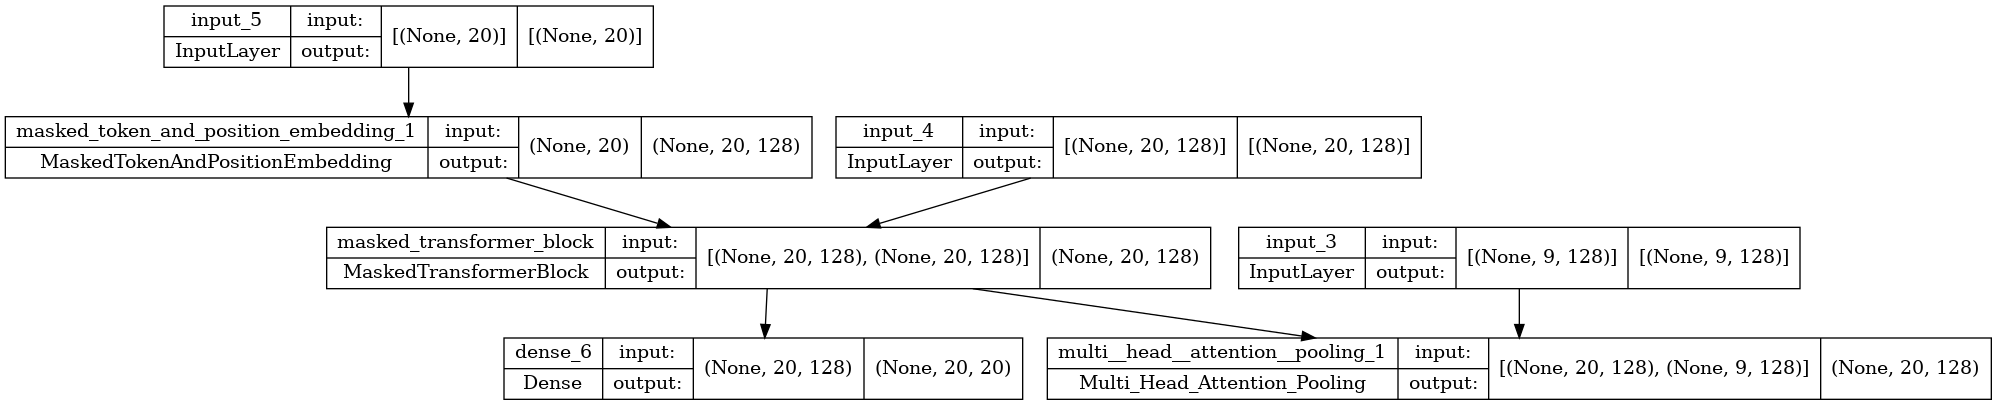

In [18]:
#Decoder 

#Context input_layer
context_decoder_layer = keras.layers.Input(shape=context_decoder.shape[1:])

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = output_sequences.shape[1])
position_embedding_layer = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(max_sentence_length)(decoder)

#Output of decoder/linear layer? should go to update context matrix with pooling
context_decoder = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([decoder, context_decoder_layer])

decoder_model = keras.Model([input_layer, encoder_input_layer, context_decoder_layer], [linear_layer, context_decoder])
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

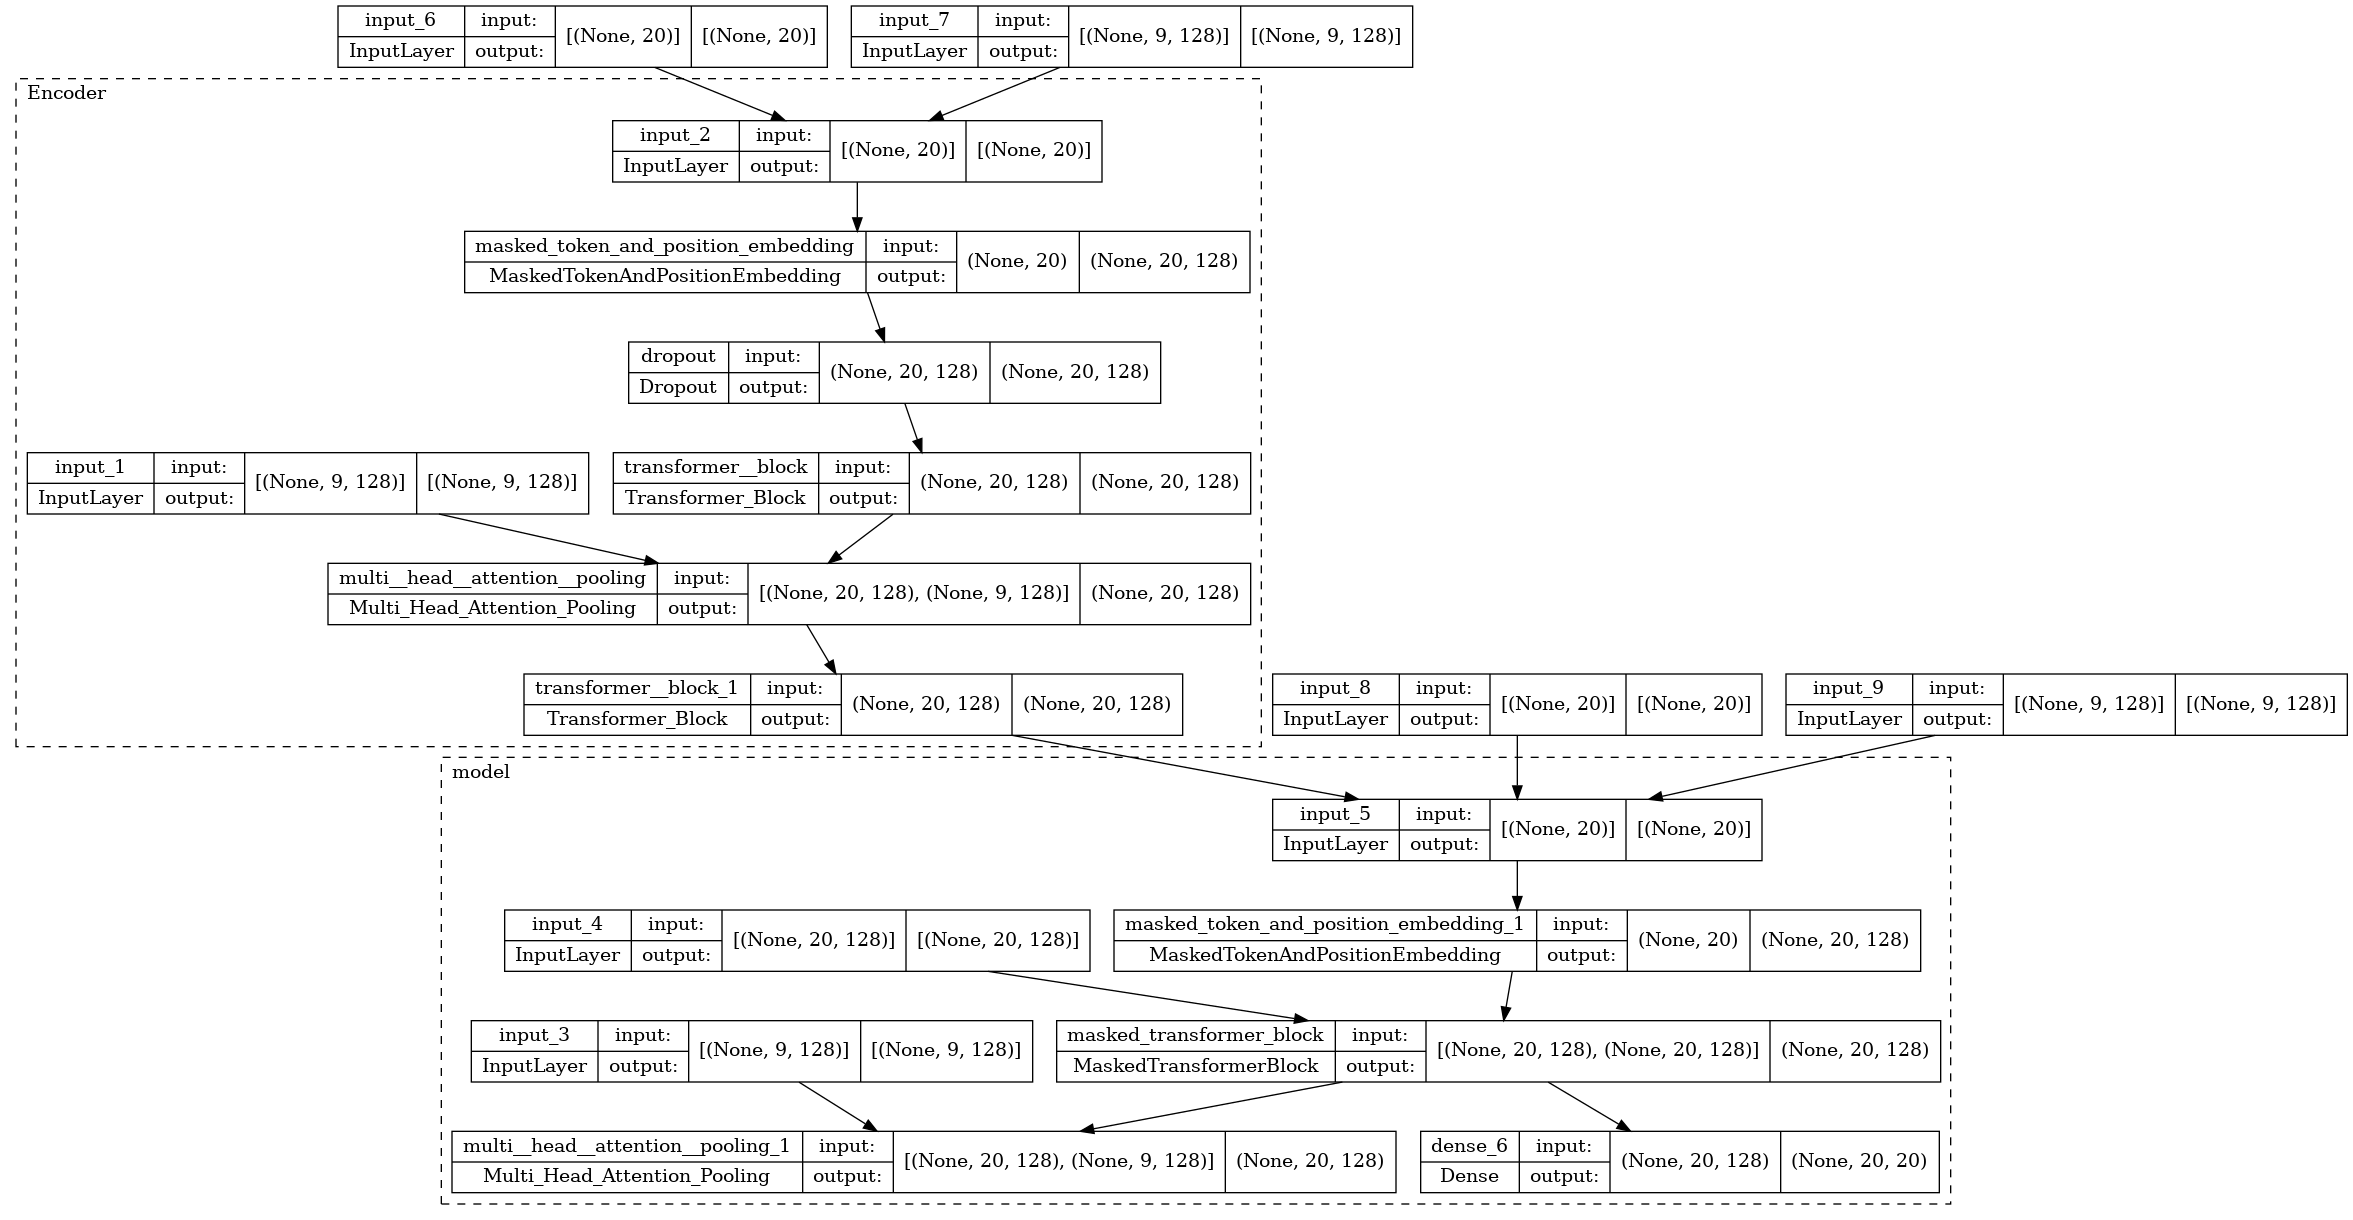

In [19]:
sequences = keras.layers.Input(encoder_model.input_shape[0][1:])
context_encoder_input = keras.layers.Input(encoder_model.input_shape[1][1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])
context_decoder_input = keras.layers.Input(decoder_model.input_shape[2][1:])


transformer = decoder_model([targets, encoder_model([sequences, context_encoder_input]), context_decoder_input])
transformer = keras.Model([sequences, context_decoder_input, targets, context_encoder_input], transformer)


keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [20]:
transformer.compile(loss=MaskedSparseCategoricalCrossentropy, optimizer=keras.optimizers.Adam(), metrics=[MaskedSparseCategoricalAccuracy])
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 9, 128)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 Encoder (Functional)           (None, 20, 128)      1600672     ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

In [25]:
context_encoder.shape

TensorShape([None, 20, 128])

In [24]:
input_sequences.shape

(9, 20)

In [21]:
batch_size = 1
epochs = 150

history = transformer.fit((input_sequences, context_encoder[1], output_sequences, context_decoder[1]), [output_sequences], batch_size=batch_size, epochs=epochs, verbose=0)

ValueError: Data cardinality is ambiguous:
  x sizes: 9, 20, 9, 20
  y sizes: 9
Make sure all arrays contain the same number of samples.